# Problem
Our problem is a classification problem, our target is whether a shot is goal or not.

# Where Can We Use This Model In Real World ?

We can use this model to analyze player performances, understand player habits on the field, determining which players to change in game or find out in advance whether a new player will be compatible with the team or not during transfer seasons.

# Imports

In [58]:

import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.robjects.packages as rpackages
from rpy2.robjects.conversion import localconverter
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import ravel
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import h2o
from h2o.automl import H2OAutoML
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [21]:
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

<rpy2.rinterface_lib.sexp.NULLType object at 0x13929ff90> [0]

# Getting Dataset Over R from Python

In [22]:
pandas2ri.activate()
ro.r('''
        library("worldfootballR")
        laliga <- load_understat_league_shots(league = "La liga")
     ''')
laliga = pandas2ri.rpy2py(ro.r['laliga'])
laliga.drop('league', axis=1, inplace=True)
data=laliga[(laliga['date'] > '2020-06-10') & (laliga['date'] < '2024-06-10')]

→ Data last updated 2024-05-30 18:34:46.012307882309 UTC


We are going to use La Liga dataset between 2020-06-10 and 2024-06-10.

# Data Manipulations and Fixes

We have a problem about NaN values and duplicate features, we are going to fix these problems by manipulating the data.

In [23]:
warnings.filterwarnings('ignore')

def fixDataNaN(df):
    with localconverter(ro.default_converter + pandas2ri.converter):
        df = ro.conversion.py2rpy(df)
pairs = [['x','X'],['y','Y'],['x_g','xG'],['h_a','home_away'],['shot_type','shotType'],['last_action','lastAction']]

def camel_case_columns(df):
    def camel_case(column_name):
        parts = column_name.split('_')
        return str(parts[0] + ''.join(x.title() for x in parts[1:]))
    
    new_columns = []
    for column in df.columns:
        if '_' in column:
            new_columns.append(camel_case(column))
        else:
            new_columns.append(str(column))
    
    df.columns = new_columns
    return df

def fixMergeColumns(dataList, pairs):
    for targetData in dataList:
        for pair in pairs:
            if pair[0] in targetData.columns and pair[1] in targetData.columns:
                targetData['{}'.format(pair[1])].fillna(targetData['{}'.format(pair[0])], inplace=True)
                targetData.drop(columns=['{}'.format(pair[0])], inplace=True)
        targetData = camel_case_columns(targetData)
        fixDataNaN(targetData)

fixMergeColumns([data], pairs)

We are going to train our model to predict whether the position ends up to a goal or not so we need to convert our goal and not goal situations to binary tags.

In [24]:
replacement_dict = {
    'Goal': 1,
    'BlockedShot': 0,
    'MissedShots': 0,
    'SavedShot': 0,
    'ShotOnPost': 0,
    'OwnGoal': 0
}

data['result'] = pd.DataFrame(data['result'].map(replacement_dict))

We changed string values to numerical values for the training to work.

In [25]:
X = data.drop('result', axis=1)
base_data = data
Y = data['result']
X = pd.get_dummies(X)
data = pd.concat([pd.DataFrame(Y),pd.DataFrame(X)], axis=1)

We split the data into training and validation data.

In [26]:
data_shuffled = data.sample(frac=1, random_state=42)
quarter_length = len(data_shuffled) // 4
df_half_val = data_shuffled.iloc[:quarter_length]
df_half_train = data_shuffled.iloc[quarter_length:]

data = df_half_train
validation_data = df_half_val

We split the validation data into X and Y.

In [27]:
Y_validation = validation_data['result']
x_validation = validation_data.drop('result', axis=1)

X = pd.DataFrame(data.drop('result', axis=1))
Y = pd.DataFrame(data['result'])

# Exploring Data

In [28]:
base_data.head(2)

,id,minute,result,X,Y,xG,player,playerId,situation,season,shotType,matchId,homeTeam,awayTeam,homeGoals,awayGoals,date,playerAssisted,lastAction,homeAway
51957,364045.0,5.0,0,0.862,0.655,0.063956,Munir,2106.0,OpenPlay,2019.0,LeftFoot,12301.0,Sevilla,Real Betis,2.0,0.0,2020-06-11 20:00:00,Sergio Reguilón,Pass,h
51958,364046.0,9.0,0,0.920,0.265,0.044106,Lucas Ocampos,1109.0,OpenPlay,2019.0,RightFoot,12301.0,Sevilla,Real Betis,2.0,0.0,2020-06-11 20:00:00,Jesús Navas,TakeOn,h


### Target Variable

Our target variable is "result", this feature represents whether a shot is a goal or not.

### Features

Our features are going to help our model to learn and predict the target variable.

In [29]:
print(base_data.columns.tolist())

['id', 'minute', 'result', 'X', 'Y', 'xG', 'player', 'playerId', 'situation', 'season', 'shotType', 'matchId', 'homeTeam', 'awayTeam', 'homeGoals', 'awayGoals', 'date', 'playerAssisted', 'lastAction', 'homeAway']


# Imbalancedness

Our data has imbalancedness problem which might cause our model to learn features of majority target variables better than the minority target variables, it might cause inaccurate predictions.

In [30]:
print(data['result'].value_counts())

result
0    25655
1     2980
Name: count, dtype: int64


### SMOTE

We are tried to use SMOTE method for oversampling to fix the gap between minority and majority target variables. This method uses clustering methods to create new observations based on original ones.

But SMOTE did not work efficient on our data, it caused overfitting problem because synthetic generated minority observations did not represent our minority class well.

We are going to disable block below since we do not use it as our primary method and for the sake of process time.

In [31]:
# sm = SMOTE(random_state=42,n_jobs=-1)
# x_res, y_res = sm.fit_resample(X, Y)

# data_res = pd.concat([pd.DataFrame(y_res), pd.DataFrame(x_res)], axis=1)
# print(y_res.value_counts())

# scaler = MinMaxScaler()

# x_res = scaler.fit_transform(x_res)

# X_validation = scaler.fit_transform(x_validation)

# Y_validation = validation_data['result']

### Undersampling

We used undersampling method to solve imbalancedness problem by decreasing majority count with sampling.

In [32]:
rus = RandomUnderSampler(random_state=42)
X_rus, Y_rus = rus.fit_resample(X, Y)
x_rus = pd.DataFrame(X_rus)
y_rus = pd.DataFrame(Y_rus)

print(y_rus.value_counts())

scaler = MinMaxScaler()

x_rus = scaler.fit_transform(x_rus)

X_validation = scaler.fit_transform(x_validation)

Y_validation = validation_data['result']

result
0         2980
1         2980
Name: count, dtype: int64


# Model Comparison Over Sampling Method

We used both SMOTE and Undersampling methods, we figured out that the SMOTE method is not working effectively on our data and causing overfitting problem, so we choose to use Undersampling method.

In [33]:
x_train_rus, x_test_rus, y_train_rus, y_test_rus = train_test_split(x_rus, y_rus, test_size=0.25, random_state=42)
# x_train_res, x_test_res, y_train_res, y_test_res = train_test_split(x_res, y_res, test_size=0.25, random_state=42)

### Model with SMOTE

In [34]:
# from sklearn.ensemble import GradientBoostingClassifier


# model_res = GradientBoostingClassifier(random_state=42)
# model_res.fit(x_train_res, y_train_res)

# y_pred_res = model_res.predict(x_test_res)

# y_train_res = y_train_res.astype(y_pred_res.dtype)

5-Fold Cross Validation score:

In [35]:
# print(cross_val_score(model_res, x_train_res, y_train_res, cv=5, scoring='balanced_accuracy').mean())

### Model with Undersampling

In [36]:
from sklearn.ensemble import GradientBoostingClassifier


model_rus = GradientBoostingClassifier(random_state=42)
model_rus.fit(x_train_rus, y_train_rus)

y_pred_rus = model_rus.predict(x_test_rus)

y_train_rus = y_train_rus.astype(y_pred_rus.dtype)

5-Fold Cross Validation score:

In [37]:
print(cross_val_score(model_rus, x_train_rus, y_train_rus, cv=5, scoring='balanced_accuracy').mean())

0.7857051326801918


# Checking Overfitting

### Model with SMOTE

We see that our model is overfitting because of the synthetic generated observations of minority class are not representing our minority class well.

In [38]:
# y_validation_pred_res = model_res.predict(X_validation)

# print(confusion_matrix(Y_validation, y_validation_pred_res))

# print(balanced_accuracy_score(Y_validation, y_validation_pred_res))

### Model with Undersampling

Our Undersampling method works well, our balanced accuracy score on validation data is good, there is no sign of overfitting because our test and validation predictions' balanced accuracy scores are close to each other also we fixed imbalancedness.

In [39]:
y_validation_pred_rus = model_rus.predict(X_validation)

print(confusion_matrix(Y_validation, y_validation_pred_rus))

print(balanced_accuracy_score(Y_validation, y_validation_pred_rus))

[[7007 1519]
 [ 247  771]]
0.7896032337465845


# Best Model and Hyperparameter Tuning with AutoML

We are going to use the H2O AutoML to find best hyperparameters and model to use.

In [40]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment AdoptOpenJDK-11.0.11+9 (build 11.0.11+9); OpenJDK 64-Bit Server VM AdoptOpenJDK-11.0.11+9 (build 11.0.11+9, mixed mode)
  Starting server from /Users/sezaiufukoral/anaconda3/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/v_/rk6mkc692tsd60fr3klt7tfm0000gn/T/tmpttwo7c7t
  JVM stdout: /var/folders/v_/rk6mkc692tsd60fr3klt7tfm0000gn/T/tmpttwo7c7t/h2o_sezaiufukoral_started_from_python.out
  JVM stderr: /var/folders/v_/rk6mkc692tsd60fr3klt7tfm0000gn/T/tmpttwo7c7t/h2o_sezaiufukoral_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Istanbul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.2
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_sezaiufukoral_eq1iiq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [41]:
new_data = pd.DataFrame(x_train_rus)
new_data['result'] = y_train_rus.values

In [42]:
hf = h2o.H2OFrame(new_data)

train_hf, test_hf = hf.split_frame(ratios=[0.75], seed = 1)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [43]:
aml = H2OAutoML(max_models = 12,
                balance_classes=True,
		seed=1,max_runtime_secs=220,verbosity='none')

aml.train(training_frame = train_hf, y='result')

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,blending
Number of base models (used / total),4/5
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DRF base models (used / total),2/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,AUTO
Metalearner nfolds,0
Metalearner fold_column,None


In [51]:
aml.leaderboard

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_1_20240610_60212,0.375952,0.14134,0.304812,0.260929,0.14134
XGBoost_3_AutoML_1_20240610_60212,0.376658,0.141872,0.295501,0.264076,0.141872
StackedEnsemble_AllModels_1_AutoML_1_20240610_60212,0.377243,0.142313,0.303459,0.262166,0.142313
GBM_3_AutoML_1_20240610_60212,0.378386,0.143176,0.2978,0.264948,0.143176
GBM_2_AutoML_1_20240610_60212,0.380769,0.144985,0.299557,0.267065,0.144985
GBM_1_AutoML_1_20240610_60212,0.381971,0.145902,0.301871,0.267389,0.145902
DRF_1_AutoML_1_20240610_60212,0.385147,0.148338,0.28332,0.268533,0.148338
GBM_5_AutoML_1_20240610_60212,0.385503,0.148612,0.302119,0.26985,0.148612
GBM_4_AutoML_1_20240610_60212,0.388627,0.151031,0.300964,0.272379,0.151031
XGBoost_grid_1_AutoML_1_20240610_60212_model_1,0.408959,0.167247,0.313975,0.285802,0.167247


# Choosing the Final Model

We are going to test our models with a new, unseen data to check balanced accuracy scores and confusion matrices to choose our final model.

In [44]:
y_validation_pred = model_rus.predict(X_validation)

print(confusion_matrix(Y_validation, y_validation_pred))

print(balanced_accuracy_score(Y_validation, y_validation_pred))

[[7007 1519]
 [ 247  771]]
0.7896032337465845


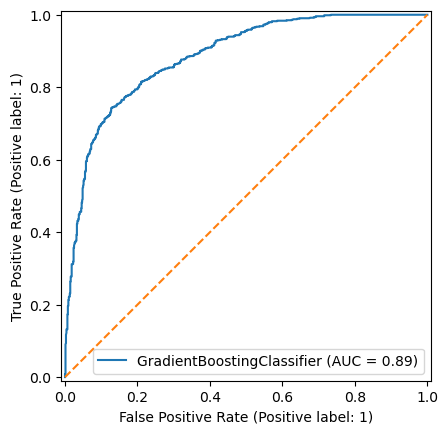

In [57]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(model_rus, x_test_rus, y_test_rus)


plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

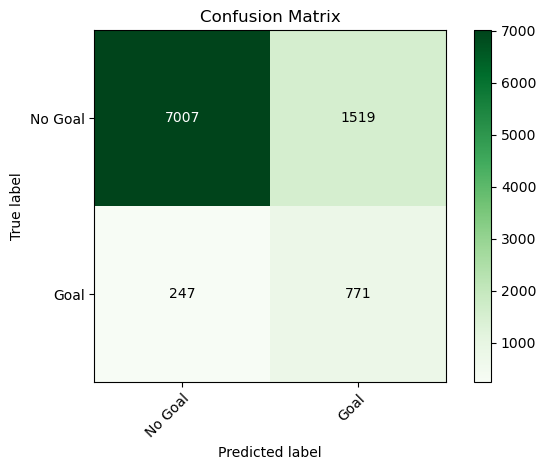

In [60]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Greens):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(Y_validation, y_validation_pred, classes=['No Goal','Goal'])
plt.show()

In [45]:
warnings.filterwarnings('ignore')

validation_x_hf = h2o.H2OFrame(pd.DataFrame(X_validation))
validation_y_hf = h2o.H2OFrame(pd.DataFrame(Y_validation))

validation_y_hf.columns = ['result']

preds_validation = aml.leader.predict(validation_x_hf)

y_validation_test_se = validation_y_hf['result'].as_data_frame().values.flatten()
y_validation_pred_se = preds_validation['predict'].round().as_data_frame().values.flatten()

balanced_acc = balanced_accuracy_score(y_validation_test_se, y_validation_pred_se)
print("Balanced Accuracy Score: ", balanced_acc)

print(confusion_matrix(y_validation_test_se, y_validation_pred_se))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Balanced Accuracy Score:  0.7877924084748051
[[7085 1441]
 [ 260  758]]


Both the Stacked Ensemble and vanilla Gradient Boosting Machines algorithms' metrics show similar performance to each other. However, given that knowing if a shot results in a goal is the dominant information we want to obtain according to domain knowledge, also for the sake of process time, we choose our model to be vanilla Gradient Boosting Machines.

In [46]:
filename = 'model.pkl'
pickle.dump(model_rus, open(filename, 'wb'))

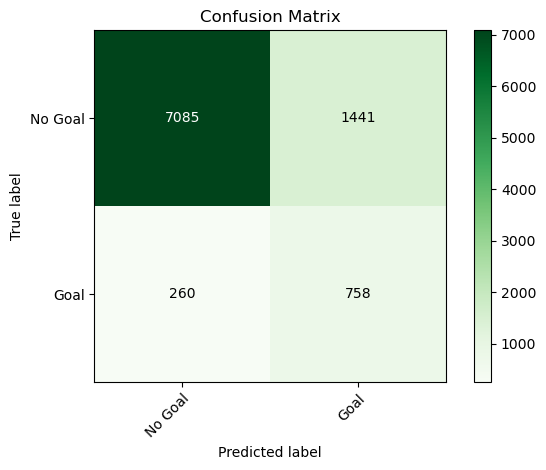

In [59]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Greens):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(y_validation_test_se, y_validation_pred_se, classes=['No Goal','Goal'])
plt.show()